In [56]:
# modules
import pickle
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from datetime import datetime
from matplotlib import cm
from matplotlib import rc
from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors


rc('animation', html='jshtml')


In [43]:
loc_clean_data = '../data/clean_data/'

### get the data for one day, to show how the data is cleaned

In [44]:
with open(loc_clean_data + 'clean_dates.txt', 'rb') as f:
    dates = pickle.load(f)

print(dates)
date = dates.date

start_date = datetime.strptime('10-12-2020', '%d-%m-%Y')
end_date = datetime.strptime('11-12-2020', '%d-%m-%Y')
idx = (start_date < date)  & (date < end_date) 

dates = dates[idx]

                                        file_name  \
0    ../data/clean_data/image_20201210-00h0457.nc   
1    ../data/clean_data/image_20201210-00h1457.nc   
2    ../data/clean_data/image_20201210-00h2457.nc   
3    ../data/clean_data/image_20201210-00h3457.nc   
4    ../data/clean_data/image_20201210-00h4457.nc   
..                                            ...   
139  ../data/clean_data/image_20201210-23h1457.nc   
140  ../data/clean_data/image_20201210-23h2457.nc   
141  ../data/clean_data/image_20201210-23h3457.nc   
142  ../data/clean_data/image_20201210-23h4457.nc   
143  ../data/clean_data/image_20201210-23h5457.nc   

                             date  
0   2020-12-10 00:04:57.823948032  
1   2020-12-10 00:14:57.818392960  
2   2020-12-10 00:24:57.820765952  
3   2020-12-10 00:34:57.816974976  
4   2020-12-10 00:44:57.811352064  
..                            ...  
139 2020-12-10 23:14:57.601948032  
140 2020-12-10 23:24:57.596071040  
141 2020-12-10 23:34:57.595847936  
142

In [208]:
file = dates.file_name.loc[0]
ds = xr.open_dataset(file)
ds

# Only keep points which are in the right area and do contain a wind speed
dss = []
for file in dates.file_name:
    ds = xr.open_dataset(file)
    dss.append(ds)

ds = xr.concat(dss, 't')

invalid =np.sum(ds.ct == 0, axis = (1,2))
ds = ds.where(invalid < 10000, drop = True)

ds

<xarray.Dataset>
Dimensions:  (t: 39, x: 441, y: 443)
Coordinates:
  * x        (x) float64 1.1e+06 1.095e+06 1.09e+06 ... -1.104e+06 -1.109e+06
  * y        (y) float64 1.113e+06 1.108e+06 1.103e+06 ... -1.102e+06 -1.107e+06
  * t        (t) datetime64[ns] 2020-12-10T11:24:57.916754048 ... 2020-12-10T...
Data variables:
    cth      (t, x, y) float32 778.9 642.8 642.8 642.8 ... nan nan nan nan
    cod      (t, x, y) float32 0.6495 0.525 1.687 3.797 ... nan nan nan nan
    ct       (t, x, y) float64 2.0 2.0 2.0 5.0 2.0 2.0 ... nan nan nan nan nan
    u        (t, x, y) float32 -6.837 5.984 5.984 5.984 ... nan nan nan nan
    v        (t, x, y) float32 -31.92 11.99 11.99 11.99 ... nan nan nan nan
Attributes:
    extent:   [-50. -30.  -5.  15.]

In [209]:
ds.u.attrs["units"] = "m s-1"
ds

<xarray.Dataset>
Dimensions:  (t: 39, x: 441, y: 443)
Coordinates:
  * x        (x) float64 1.1e+06 1.095e+06 1.09e+06 ... -1.104e+06 -1.109e+06
  * y        (y) float64 1.113e+06 1.108e+06 1.103e+06 ... -1.102e+06 -1.107e+06
  * t        (t) datetime64[ns] 2020-12-10T11:24:57.916754048 ... 2020-12-10T...
Data variables:
    cth      (t, x, y) float32 778.9 642.8 642.8 642.8 ... nan nan nan nan
    cod      (t, x, y) float32 0.6495 0.525 1.687 3.797 ... nan nan nan nan
    ct       (t, x, y) float64 2.0 2.0 2.0 5.0 2.0 2.0 ... nan nan nan nan nan
    u        (t, x, y) float32 -6.837 5.984 5.984 5.984 ... nan nan nan nan
    v        (t, x, y) float32 -31.92 11.99 11.99 11.99 ... nan nan nan nan
Attributes:
    extent:   [-50. -30.  -5.  15.]

144

### Animate cloud types and show advection for a couple of pixels

In [239]:
# pixel path

def nextLoc(ds, s, i, j
           ):
    """
    Function which determines the next location for a pixel at (k, i, j)
    t[k], x[i], y[j]
    returns new indices
    """
    
    t1 = ds.t[k] 
    x = ds.x[i]
    y = ds.y[j]

    dt = ds.t[k+1] - t1

    dt = (ds.t[k+1].data - t1.data ) 

    dx = ds.u[k,i,j].data * dt / np.timedelta64(1, 's') # m
    dy = ds.v[k,i,j].data * dt / np.timedelta64(1, 's') # m

    x_new = x + dx
    y_new = y + dy

    # First, find the index of the grid point nearest a specific lat/lon.   
    absx = np.abs(ds.x-x_new)
    absy = np.abs(ds.y-y_new)
    c = np.maximum(absx, absy)

    ([xloc], [yloc]) = np.where(c == np.min(c))

    
    return  xloc,yloc


i, j = [50, 50, 50, 150, 150, 150, 250, 250, 250, 350, 350, 350], 4 * [50, 150, 250]
i_start, j_start = [50, 50, 50, 150, 150, 150, 250, 250, 250, 350, 350, 350], 4 * [50, 150, 250]
x = np.zeros((ds.t.size, len(i)))
y = np.zeros((ds.t.size, len(i)))

x[0, :] = ds.x[i]
y[0, :] = ds.y[j]

xloc = np.zeros((ds.t.size, len(i)))
yloc = np.zeros((ds.t.size, len(i)))

xloc[0, :] = i
yloc[0, :] = j

for k in range(0, ds.t.size-1):
    for p in range(len(i)):
        print(k ,i[p], j[p], p , '           ', end = '\r')
        try:
            i[p], j[p] = nextLoc(ds, k, i[p], j[p])
        except ValueError:
            i[p], j[p] = i_start[p], j_start[p]
    x[k+1, :] = ds.x[i]
    y[k+1, :] = ds.y[j]
    xloc[k+1, :] = i
    yloc[k+1, :] = j



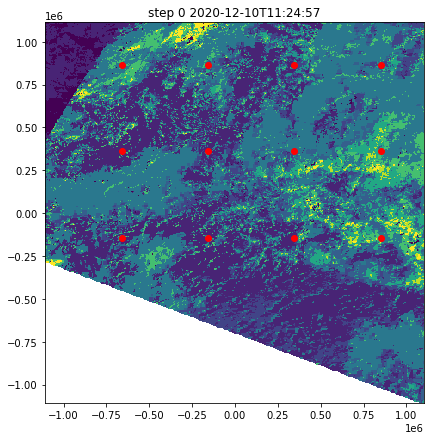

In [211]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
# ax2 = fig.add_subplot(122)
# cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
norm = colors.Normalize(vmin=0, vmax=10)

def animate(i):
    ax.clear()
    ax.set_title(f'step {i} {ds.t[i].data.astype("datetime64[s]")}')
    plot = ax.pcolormesh(grid_x, grid_y, ds.ct[i,:,:].T, norm = norm)
    ax.plot(x[:i], y[:i], 'k')
    ax.scatter(x[i], y[i], color = 'r')
    ax.set_aspect('equal')
#     ax2.hist(ca.h[i,:,:].data.flatten())
#     cb = fig.colorbar(plot, ax = ax)
    return plot

# Create animation
ani = FuncAnimation(fig=fig, func=animate,
                    frames= range(ds.t.size), 
                    interval=500, repeat=True)

ani

In [186]:
ani.save('../fig/advectionOneDay.mp4')

In [252]:
ds.ct

<xarray.DataArray 'ct' (t: 39, x: 441, y: 443)>
array([[[ 2.,  2.,  2., ...,  5.,  5.,  2.],
        [ 2.,  2.,  2., ...,  5.,  5.,  5.],
        [ 2.,  2.,  2., ...,  2.,  2., nan],
        ...,
        [ 0.,  0.,  1., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 2.,  2.,  2., ...,  3.,  5.,  2.],
        [ 2.,  2.,  2., ...,  3.,  5.,  5.],
        [ 2.,  2.,  2., ...,  3.,  5., nan],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 2.,  5.,  2., ...,  6.,  2.,  2.],
        [ 2.,  2.,  2., ...,  3.,  2.,  2.],
        [ 2.,  3.,  6., ...,  6.,  5., nan],
        ...,
...
        ...,
        [ 6.,  3.,  6., ..., nan, nan, nan],
        [ 9.,  6.,  3., ..., nan, nan, nan],
        [ 6.,  9.,  9., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  2.,  1.,  2.],
        [ 0.,  0.,  0., ...,  2.,  1.,  1.],
        [ 0.,  0.,  0., ...,  2.,  2., nan],
        ...,
        [ 6.,  6.,  6., ..., nan, nan, nan],
        [ 6.,  6.,  3., ..., nan, nan, nan],
        [ 6.,  6.,  9., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  2.,  2.],
        [ 0.,  0.,  0., ...,  3.,  0.,  1.],
        [ 0.,  0.,  0., ...,  3.,  2., nan],
        ...,
        [ 6.,  6.,  3., ..., nan, nan, nan],
        [ 6.,  3.,  3., ..., nan, nan, nan],
        [ 3.,  6.,  9., ..., nan, nan, nan]]])
Coordinates:
  * x        (x) float64 1.1e+06 1.095e+06 1.09e+06 ... -1.104e+06 -1.109e+06
  * y        (y) float64 1.113e+06 1.108e+06 1.103e+06 ... -1.102e+06 -1.107e+06
  * t        (t) datetime64[ns] 2020-12-10T11:24:57.916754048 ... 2020-12-10T...

In [267]:
ct_adv = np.zeros((ds.t.size, len(j)))
ct_nonadv = np.zeros((ds.t.size, len(j)))
for i in range(ds.t.size):
#     print(i, xloc[i,p], yloc[i,p])
    for p in range(len(j)):
        ct_adv[i, p] = ds.ct[i, int(xloc[i, p]), int(yloc[i,p]) ]
        ct_nonadv[i,p] = ds.ct[i, int(xloc[0, p]), int(yloc[0,p]) ]

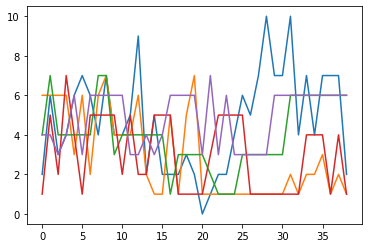

In [268]:
plt.plot(ct_adv[:,:5])

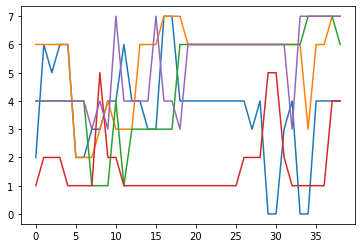

In [269]:
plt.plot(ct_nonadv[:,:5])

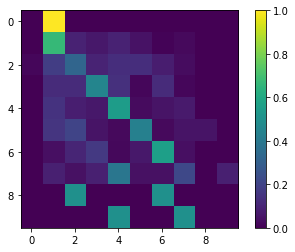

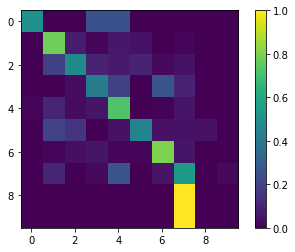

to    0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   10.0
from                                                            
0.0      2     0     0     1     1     0     0     0     0     0
1.0      0   110    11     2     9     7     0     2     0     0
2.0      0     8    20     4     3     4     1     2     0     0
3.0      0     0     1    13     6     0     8     3     0     0
4.0      2    11     3     6    77     0     1     6     0     0
5.0      0     4     3     0     1     9     1     1     1     0
6.0      0     1     3     4     1     1    57     4     0     0
7.0      0     4     0     1    10     0     2    21     0     1
8.0      0     0     0     0     0     0     0     1     0     0
10.0     0     0     0     0     0     0     0     1     0     0

In [291]:
import pandas as pd

def transitionMatrix(ct):
    df = pd.DataFrame(ct)
    nanrow = pd.DataFrame(np.nan * np.zeros((1,12)))
    to = df.append(nanrow)
    fr = nanrow.append(df)

    to = np.array(to).flatten()
    fr = np.array(fr).flatten()
    M = pd.crosstab(fr, to,
                        rownames = ['from'],
                        colnames = ['to'],
        #                 normalize = 'index'
                       )
    return M

def plotMnorm(M):
    M_norm = M.div(M.sum(axis=1), axis=0)
    plt.imshow(M_norm)
    plt.colorbar()

M_adv = transitionMatrix(ct_adv)
M_nonadv = transitionMatrix(ct_nonadv)

plotMnorm(M_adv)
plt.show()
plotMnorm(M_nonadv)
plt.show()
M_nonadv


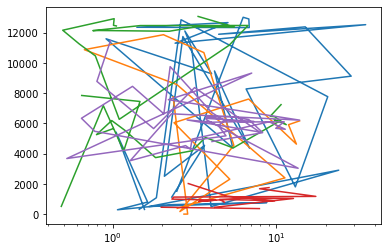

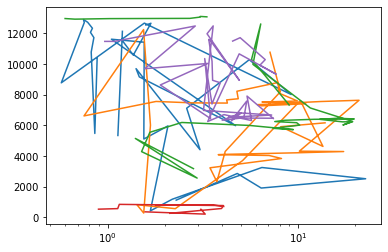

In [299]:
cth_adv = np.zeros((ds.t.size, len(j)))
cth_nonadv = np.zeros((ds.t.size, len(j)))
cod_adv = np.zeros((ds.t.size, len(j)))
cod_nonadv = np.zeros((ds.t.size, len(j)))
for i in range(ds.t.size):
#     print(i, xloc[i,p], yloc[i,p])
    for p in range(len(j)):
        cth_adv[i, p] = ds.cth[i, int(xloc[i, p]), int(yloc[i,p]) ]
        cth_nonadv[i,p] = ds.cth[i, int(xloc[0, p]), int(yloc[0,p]) ]
        cod_adv[i, p] = ds.cod[i, int(xloc[i, p]), int(yloc[i,p]) ]
        cod_nonadv[i,p] = ds.cod[i, int(xloc[0, p]), int(yloc[0,p]) ]

for p in range(5):
    plt.plot(cod_adv[:,p], cth_adv[:,p])
    plt.xscale('log')
plt.show()

for p in range(5):
    plt.plot(cod_nonadv[:,p], cth_nonadv[:,p])
    plt.xscale('log')
plt.show()